In [3]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
import tensorflow as tf
import nltk


Using TensorFlow backend.


In [0]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [0]:
captions = open(token, 'r').read().strip().split('\n')

In [16]:
captions[0].split('\t')[1]

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [17]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [0]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [0]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [0]:
img = glob.glob(images+'*.jpg')

In [20]:
img[:5]

['Flickr8k_Dataset/Flicker8k_Dataset/2199200615_85e4c2a602.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3004287781_c041c09c16.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1446053356_a924b4893f.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2043427251_83b746da8e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2888408966_376c195b3f.jpg']

In [0]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [0]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [0]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [24]:
# Getting the training images from all the images 
train_img = split_data(train_images)
len(train_img)

6000

In [0]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [27]:
# Getting the validation images from all the images# Gettin 
val_img = split_data(val_images)
len(val_img)

1000

In [0]:
test_images_file  = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [29]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

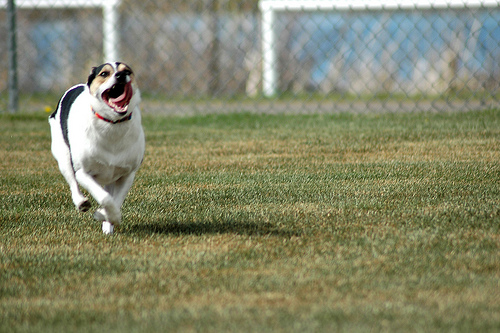

In [30]:
Image.open(train_img[0])

In [0]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [0]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [34]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 9s 0us/step


In [0]:
new_input = model.input
hidden_layer = model.layers[-2].output
model_new = Model(new_input, hidden_layer)

In [0]:
tryi = model_new.predict(preprocess(train_img[0]))

In [37]:
tryi.shape

(1, 2048)

In [0]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [39]:
encode(train_img[0]).shape

(2048,)

In [40]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [05:01<00:00, 19.90it/s]


In [0]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [0]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [43]:
encoding_train ['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [44]:
encoding_test  = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [00:49<00:00, 20.02it/s]


In [0]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [0]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [47]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [0]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [51]:
len(train_d)

6000

In [52]:
train_d[images+'3556792157_d09d42bef7.jpg']    

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [0]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [0]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [0]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [0]:
words = [i.split() for i in caps]

In [0]:
unique = []
for i in words:
    unique.extend(i)

In [0]:
unique = list(set(unique))

In [0]:
with open("unique.p", "wb") as pickle_d:
     pickle.dump(unique, pickle_d)

In [0]:
unique = pickle.load(open('unique.p', 'rb'))

In [61]:
len(unique)

8256

In [0]:
word2idx = {val:index for index, val in enumerate(unique)}

In [63]:
word2idx['<start>']

877

In [0]:
idx2word = {index:val for index, val in enumerate(unique)}

In [65]:
idx2word[877]

'<start>'

In [66]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [0]:
vocab_size = len(unique)

In [68]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [0]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [0]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [71]:
len(df)

30000

In [72]:
c = [i for i in df['captions']]
len(c)

30000

In [0]:
imgs = [i for i in df['image_id']]

In [74]:
a = c[-1]
a, imgs[-1]

('<start> Four boys play on a merry-go-round at a park . <end>',
 '2872743471_30e0d1a90a.jpg')

In [75]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 877
Four => 5648
boys => 7057
play => 2840
on => 7686
a => 6868
merry-go-round => 4402
at => 398
a => 6868
park => 3585
. => 5974
<end> => 2559


In [0]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [77]:
samples_per_epoch

383454

In [0]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [0]:
embedding_size = 300

In [0]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [0]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [82]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


In [0]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [84]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 80, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_3 (Dense)              (None, 8256)              4235328   
_________________________________________________________________
activation_95 (Activation)   (None, 8256)              0         
Total params: 9,115,032
Trainable params: 9,115,032
Non-trainable params: 0
_________________________________________________________________


In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=1) 